In [ ]:
# === 0) Imports necesarios ===

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [23]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod.csv", sep=";", decimal=".", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y
exog_cols=None #Asignar None a exog_cols para no usar variables exógenas aún

In [24]:
# === 2a) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0: 
    df.drop(columns=['Covid'], inplace=True)
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()

In [ ]:
# === 2b) Condicional para usar transformación logarítmica en la variable objetivo ===
USE_LOG_TARGET = False  # Indica si se debe usar la transformación logarítmica en la variable objetivo

# Condicional para aplicar la transformación logarítmica a la variable objetivo
def y_to_model_space(y):
    y = np.asarray(y)
    return np.log1p(np.clip(y, 0, None))  

def y_to_original_space(y_model):
    y_model = np.asarray(y_model)
    return np.expm1(y_model)

In [26]:
# === 3) Creación del dataframe final con las variables exógenas  ===
# Si exog_cols es None, se asume que no hay variables exógenas y se toman todas las columnas excepto 'date' y 'value'
if exog_cols is None:
     exog_cols = [c for c in df.columns if c not in ["date", "value"]]

# Bucle para transformar y preparar las variables exógenas
for c in exog_cols: # Transformar y preparar las variables exógenas
    df[c] = df[c].astype(str) # Convertir a string para reemplazar comas
    df[c] = df[c].str.replace(",", ".", regex=False) # Reemplazar comas por puntos decimales
    df[c] = pd.to_numeric(df[c], errors="coerce") # Convertir a numérico, forzando errores a NaN

EXOG_COLS = exog_cols.copy() # Guardar las columnas exógenas originales

target_col = "value"   # Determinar la columna objetivo
df["date"] = pd.to_datetime(df["date"]) # Se ajusta el formato de la columna data

# Crear el dataframe final con las variables exógenas y la variable objetivo
data = pd.concat(
    [df[["date"]], y_masked, df[EXOG_COLS]],
    axis=1
)

In [27]:
# === 4) Función para crear características adicionales ===

# Esta función añade características adicionales al dataframe, como lags, medias móviles, diferencias y componentes estacionales.
def add_features(data, target_col="value", exog_cols=None):
    
    d = data.copy() # Se crea una copia del df para no errar
    
    # Bucle para crear lags de la variable objetivo
    for lag in [1, 3, 6, 9, 12, 18, 24]:
        d[f"y_lag_{lag}"] = d[target_col].shift(lag) # Creación de diferentes lags para la variable objectivo

    # Mediass y desviación estandard desplazadas
    d["y_roll_mean_3"]  = d[target_col].rolling(3).mean().shift(1)
    d["y_roll_mean_6"]  = d[target_col].rolling(6).mean().shift(1)
    d["y_roll_mean_9"]  = d[target_col].rolling(9).mean().shift(1)
    d["y_roll_mean_12"] = d[target_col].rolling(12).mean().shift(1)
    d["y_roll_std_6"]   = d[target_col].rolling(6).std().shift(1)

    # Diferencias sin fuga de información
    d["y_diff_1"]  = d[target_col].shift(1) - d[target_col].shift(2)
    d["y_diff_6"]  = d[target_col].shift(1) - d[target_col].shift(7)
    d["y_diff_12"] = d[target_col].shift(1) - d[target_col].shift(13)

    # Estacionalidad capturada mediante SIN y COS
    d["month"] = d["date"].dt.month.astype(int)
    d["year"]  = d["date"].dt.year.astype(int)
    d["sin_m"] = np.sin(2*np.pi*d["month"]/12.0)
    d["cos_m"] = np.cos(2*np.pi*d["month"]/12.0)
    
    # Componente de tendencia
    if "Tendencia" in d.columns:
        d["Tendencia_lag1"] = d["Tendencia"].shift(1)
        d["Tendencia_lag2"] = d["Tendencia"].shift(2)
    
    # Componente de estacionalidad
    if exog_cols:
        numeric_exogs = [c for c in exog_cols if is_numeric_dtype(d[c])]  # Assegurar que todas las columnas en de la variable exog_cols son numéricas
        for c in numeric_exogs: # Bucle para crear la variable desplazada por cada una de las columnas en la variable exog_cols
            d[f"{c}_lag_1"]  = d[c].shift(1)
            d[f"{c}_lag_12"] = d[c].shift(12)
            d[f"{c}_x_sinm"] = d[c] * d["sin_m"] # Bucle para crear la variable desplazada por cada una de las columnas en la variable exog_cols multiplicando por la componente sinusoidal

        # Componente de estacionalidad para variables específicas
        if "Temperatura" in d.columns and is_numeric_dtype(d["Temperatura"]):
            d["Temp_anomalia"] = d["Temperatura"] - d["Temperatura"].rolling(12).mean()
        if "Precipitación" in d.columns and is_numeric_dtype(d["Precipitación"]):
            d["Precip_rolling_3"] = d["Precipitación"].rolling(3).mean()

    d = d.dropna().reset_index(drop=True)
    return d

#Llamada de la función de agregación de "features"
df_full = add_features(data, target_col, exog_cols)
# print(df_full.head(10))

In [28]:
# === 5) Definición de funciones para el cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }


In [29]:
# === 6) Valores constantes de los hiperparmámetros

EXOG_COLS = None  # Asignar None a exog_cols para no usar variables exógenas aún
N_TRIALS = 40  # Número de pruebas para la optimización de hiperparámetros  
N_SPLITS = 4  # Número de divisiones para la validación cruzada en series temporales    

In [30]:
# === 7) Preparar los conjuntos de entrenamiento y prueba ===

FEATURES = [c for c in df_full.columns if c not in ["date", "value"]]  # Lista de variables exógenas excluyendo la fecha y la variable objetivo
TARGET = target_col # Columna objetivo

n = len(df_full)  # Número total de filas en el DataFrame
split_idx = int(n * 0.8) # Índice de división
train_df = df_full.iloc[:split_idx].copy() # Conjunto de entrenamiento
test_df  = df_full.iloc[split_idx:].copy() # Conjunto de prueba

X_train, y_train = train_df[FEATURES], train_df[TARGET] # Variables y objetivo de entrenamiento
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]  # Variables y objetivo de prueba


# Se necesita más adelante para calculo de residuos
# train_log = np.log(np.clip(train['value'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
# test_log  = np.log(np.clip(test['value'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

In [31]:
# === 8) Optimización de hiperparámetros con validación cruzada en series temporales ===

tscv = TimeSeriesSplit(n_splits=N_SPLITS) # Dividir los datos en N_SPLITS para validación cruzada en series temporales

# Función objetivo para la optimización de hiperparámetros con Optuna
def objective(trial: optuna.trial.Trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "random_state": 42,
        "verbosity": -1,      # esto ya silencia el modelo
        "boosting_type": "gbdt",

        # espacio de búsqueda
        "num_leaves": trial.suggest_int("num_leaves", 15, 127),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    rmses = []
    # Entrenamiento y validación cruzada en series temporales
    for tr_idx, va_idx in tscv.split(X_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # Crear el modelo LGBMRegressor con los hiperparámetros sugeridos
        model = LGBMRegressor(**params)
        # Si se usa transformación logarítmica, ajustar el modelo a los datos transformados
        # y evaluar en la escala original
        # Si no se usa transformación logarítmica, ajustar el modelo a los datos originales
        if USE_LOG_TARGET:
            # Entrenamos en log(y), pero evaluamos en escala original
            y_tr_fit = y_to_model_space(y_tr)
            y_va_fit = y_to_model_space(y_va)

            model.fit(
                X_tr, 
                y_tr_fit,
                eval_set=[(X_va, y_va_fit)],
                eval_metric="rmse"
            )

            y_hat_log = model.predict(X_va)
            y_hat = y_to_original_space(y_hat_log)
        else:
            model.fit(
                X_tr, 
                y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric="rmse"
            )
            y_hat = model.predict(X_va)
        # Calcular el RMSE en la escala original
        rmse_value = rmse(y_va, y_hat)  # siempre en escala original
        rmses.append(rmse_value)
        # Reportar el RMSE al trial de Optuna
        trial.report(float(np.mean(rmses)), step=len(rmses))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(rmses))

optimización = optuna.create_study(direction="minimize", study_name="lgbm_ts_enhanced") # Optimización de hiperparámetros con Optuna
optimización.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True) # Ejecutar la optimización de hiperparámetros

# Imprimir los mejores hiperparámetros y el mejor RMSE
print("Mejores hiperparámetros:", optimización.best_params)
print(f"Mejor RMSE CV: {optimización.best_value:.3f}")
best_params_optuna = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 42,
    "verbosity": -1,
    "boosting_type": "gbdt",
    **optimización.best_params
}


[I 2025-12-07 20:23:42,227] A new study created in memory with name: lgbm_ts_enhanced
Best trial: 0. Best value: 3881.11:   5%|▌         | 2/40 [00:00<00:04,  8.24it/s]

[I 2025-12-07 20:23:42,360] Trial 0 finished with value: 3881.111758054302 and parameters: {'num_leaves': 26, 'max_depth': 13, 'learning_rate': 0.016434910285062037, 'n_estimators': 1645, 'min_child_samples': 93, 'subsample': 0.583268359914926, 'colsample_bytree': 0.6473225407319817}. Best is trial 0 with value: 3881.111758054302.
[I 2025-12-07 20:23:42,472] Trial 1 finished with value: 3881.111758054302 and parameters: {'num_leaves': 67, 'max_depth': 12, 'learning_rate': 0.055863442344729675, 'n_estimators': 1560, 'min_child_samples': 71, 'subsample': 0.9353073300905707, 'colsample_bytree': 0.768501418407123}. Best is trial 0 with value: 3881.111758054302.


Best trial: 2. Best value: 3879.63:   8%|▊         | 3/40 [00:00<00:06,  5.71it/s]

[I 2025-12-07 20:23:42,711] Trial 2 finished with value: 3879.6337314784487 and parameters: {'num_leaves': 92, 'max_depth': 16, 'learning_rate': 0.004926541166727184, 'n_estimators': 1207, 'min_child_samples': 13, 'subsample': 0.7798756112638188, 'colsample_bytree': 0.5611834732395016}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  12%|█▎        | 5/40 [00:00<00:05,  6.43it/s]

[I 2025-12-07 20:23:42,896] Trial 3 finished with value: 3925.112325468079 and parameters: {'num_leaves': 120, 'max_depth': 4, 'learning_rate': 0.0016079238640371912, 'n_estimators': 1257, 'min_child_samples': 20, 'subsample': 0.9691894233001831, 'colsample_bytree': 0.7360064965247508}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:43,011] Trial 4 finished with value: 3881.111758054302 and parameters: {'num_leaves': 115, 'max_depth': 16, 'learning_rate': 0.003501555512562892, 'n_estimators': 1919, 'min_child_samples': 66, 'subsample': 0.6434343650614871, 'colsample_bytree': 0.6980360970808228}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:43,050] Trial 5 finished with value: 3881.111758054302 and parameters: {'num_leaves': 114, 'max_depth': 8, 'learning_rate': 0.07950333475087892, 'n_estimators': 351, 'min_child_samples': 83, 'subsample': 0.6899367335478992, 'colsample_bytree': 0.9150130275146128}. Best is trial 2 with value: 3879.6337314784

Best trial: 2. Best value: 3879.63:  20%|██        | 8/40 [00:01<00:04,  7.63it/s]

[I 2025-12-07 20:23:43,200] Trial 6 finished with value: 3961.9915834432813 and parameters: {'num_leaves': 95, 'max_depth': 11, 'learning_rate': 0.0018015500682996373, 'n_estimators': 999, 'min_child_samples': 19, 'subsample': 0.7407663403248019, 'colsample_bytree': 0.5684393592268462}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:43,348] Trial 7 finished with value: 3881.111758054302 and parameters: {'num_leaves': 72, 'max_depth': 15, 'learning_rate': 0.1580187462295792, 'n_estimators': 1961, 'min_child_samples': 68, 'subsample': 0.647152435292671, 'colsample_bytree': 0.5256152793695696}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  25%|██▌       | 10/40 [00:01<00:03,  9.23it/s]

[I 2025-12-07 20:23:43,399] Trial 8 finished with value: 3881.111758054302 and parameters: {'num_leaves': 125, 'max_depth': 11, 'learning_rate': 0.004582496384315582, 'n_estimators': 332, 'min_child_samples': 78, 'subsample': 0.8361755787421101, 'colsample_bytree': 0.7187031418097405}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:43,505] Trial 9 finished with value: 3881.111758054302 and parameters: {'num_leaves': 66, 'max_depth': 12, 'learning_rate': 0.05362902306521839, 'n_estimators': 1501, 'min_child_samples': 100, 'subsample': 0.9136515025612741, 'colsample_bytree': 0.5655240425701182}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:43,577] Trial 10 finished with value: 3881.111758054302 and parameters: {'num_leaves': 35, 'max_depth': 8, 'learning_rate': 0.015158638318353151, 'n_estimators': 772, 'min_child_samples': 40, 'subsample': 0.5091584834608085, 'colsample_bytree': 0.8723557373242519}. Best is trial 2 with value: 3879.63373147844

Best trial: 2. Best value: 3879.63:  35%|███▌      | 14/40 [00:02<00:04,  6.32it/s]

[I 2025-12-07 20:23:44,198] Trial 11 finished with value: 3905.5863549851633 and parameters: {'num_leaves': 36, 'max_depth': 14, 'learning_rate': 0.013129607015046051, 'n_estimators': 1583, 'min_child_samples': 5, 'subsample': 0.5328080780859872, 'colsample_bytree': 0.6395895132170413}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:44,288] Trial 12 finished with value: 3881.111758054302 and parameters: {'num_leaves': 22, 'max_depth': 14, 'learning_rate': 0.012775529155325129, 'n_estimators': 1206, 'min_child_samples': 48, 'subsample': 0.82055486506742, 'colsample_bytree': 0.6125808519107914}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:44,364] Trial 13 finished with value: 3881.111758054302 and parameters: {'num_leaves': 85, 'max_depth': 16, 'learning_rate': 0.007402779067294019, 'n_estimators': 896, 'min_child_samples': 100, 'subsample': 0.5848043842143651, 'colsample_bytree': 0.5102386540288794}. Best is trial 2 with value: 3879.633731478

Best trial: 2. Best value: 3879.63:  38%|███▊      | 15/40 [00:02<00:03,  6.65it/s]

[I 2025-12-07 20:23:44,483] Trial 14 finished with value: 3881.111758054302 and parameters: {'num_leaves': 52, 'max_depth': 13, 'learning_rate': 0.027217238707247154, 'n_estimators': 1705, 'min_child_samples': 34, 'subsample': 0.7987373378187259, 'colsample_bytree': 0.9998517442089977}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:44,568] Trial 15 pruned. 


Best trial: 2. Best value: 3879.63:  42%|████▎     | 17/40 [00:02<00:03,  7.57it/s]

[I 2025-12-07 20:23:44,684] Trial 16 finished with value: 3881.111758054302 and parameters: {'num_leaves': 51, 'max_depth': 16, 'learning_rate': 0.0010966231536621335, 'n_estimators': 1731, 'min_child_samples': 54, 'subsample': 0.8804390160546249, 'colsample_bytree': 0.8035432908948594}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:44,773] Trial 17 finished with value: 4293.897701529929 and parameters: {'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.007373308912816827, 'n_estimators': 689, 'min_child_samples': 25, 'subsample': 0.5787030571440925, 'colsample_bytree': 0.6807538419456519}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  48%|████▊     | 19/40 [00:02<00:02,  8.40it/s]

[I 2025-12-07 20:23:44,871] Trial 18 finished with value: 3881.111758054302 and parameters: {'num_leaves': 100, 'max_depth': 14, 'learning_rate': 0.02916220777035323, 'n_estimators': 1358, 'min_child_samples': 87, 'subsample': 0.6848211893905632, 'colsample_bytree': 0.5736404544671132}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:44,954] Trial 19 finished with value: 3881.111758054302 and parameters: {'num_leaves': 81, 'max_depth': 6, 'learning_rate': 0.023559559429033965, 'n_estimators': 1068, 'min_child_samples': 58, 'subsample': 0.7561837028094012, 'colsample_bytree': 0.6659513473467571}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  55%|█████▌    | 22/40 [00:02<00:02,  8.84it/s]

[I 2025-12-07 20:23:45,075] Trial 20 finished with value: 3881.111758054302 and parameters: {'num_leaves': 53, 'max_depth': 10, 'learning_rate': 0.006960751951147559, 'n_estimators': 1801, 'min_child_samples': 42, 'subsample': 0.5952882896086333, 'colsample_bytree': 0.8023546154963044}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:45,187] Trial 21 finished with value: 3881.111758054302 and parameters: {'num_leaves': 65, 'max_depth': 12, 'learning_rate': 0.0568269407283719, 'n_estimators': 1559, 'min_child_samples': 90, 'subsample': 0.987798213166599, 'colsample_bytree': 0.7928088001945163}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  57%|█████▊    | 23/40 [00:03<00:01,  8.89it/s]

[I 2025-12-07 20:23:45,296] Trial 22 finished with value: 3881.111758054302 and parameters: {'num_leaves': 107, 'max_depth': 13, 'learning_rate': 0.15099458204763738, 'n_estimators': 1440, 'min_child_samples': 72, 'subsample': 0.9213788190728587, 'colsample_bytree': 0.7718290897841656}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:45,388] Trial 23 finished with value: 3881.111758054302 and parameters: {'num_leaves': 83, 'max_depth': 13, 'learning_rate': 0.043006422740638636, 'n_estimators': 1237, 'min_child_samples': 92, 'subsample': 0.8711278408824009, 'colsample_bytree': 0.6054686745583933}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  65%|██████▌   | 26/40 [00:03<00:01,  8.87it/s]

[I 2025-12-07 20:23:45,500] Trial 24 finished with value: 3881.111758054302 and parameters: {'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.07844047228074977, 'n_estimators': 1626, 'min_child_samples': 75, 'subsample': 0.7858094746325613, 'colsample_bytree': 0.8535808621483324}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:45,628] Trial 25 finished with value: 3881.111758054302 and parameters: {'num_leaves': 74, 'max_depth': 15, 'learning_rate': 0.014962954200928082, 'n_estimators': 1880, 'min_child_samples': 61, 'subsample': 0.679389010663244, 'colsample_bytree': 0.5434052720616451}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  70%|███████   | 28/40 [00:03<00:01,  9.50it/s]

[I 2025-12-07 20:23:45,716] Trial 26 finished with value: 3881.111758054302 and parameters: {'num_leaves': 15, 'max_depth': 15, 'learning_rate': 0.0024009185664141336, 'n_estimators': 1087, 'min_child_samples': 81, 'subsample': 0.8547845768691452, 'colsample_bytree': 0.6592940616999736}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:45,817] Trial 27 finished with value: 3881.111758054302 and parameters: {'num_leaves': 62, 'max_depth': 12, 'learning_rate': 0.008649772910570251, 'n_estimators': 1417, 'min_child_samples': 94, 'subsample': 0.9292231774960269, 'colsample_bytree': 0.7536742167456338}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  72%|███████▎  | 29/40 [00:03<00:01,  9.21it/s]

[I 2025-12-07 20:23:45,936] Trial 28 finished with value: 3881.111758054302 and parameters: {'num_leaves': 44, 'max_depth': 10, 'learning_rate': 0.09497901514124589, 'n_estimators': 1644, 'min_child_samples': 47, 'subsample': 0.7206354907724783, 'colsample_bytree': 0.6129024530091921}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  78%|███████▊  | 31/40 [00:04<00:01,  7.90it/s]

[I 2025-12-07 20:23:46,123] Trial 29 finished with value: 4219.296885673637 and parameters: {'num_leaves': 29, 'max_depth': 3, 'learning_rate': 0.0215162378720924, 'n_estimators': 1255, 'min_child_samples': 20, 'subsample': 0.6299324470138326, 'colsample_bytree': 0.7195861814645048}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:46,250] Trial 30 finished with value: 3881.111758054302 and parameters: {'num_leaves': 89, 'max_depth': 14, 'learning_rate': 0.005126235610579564, 'n_estimators': 1788, 'min_child_samples': 64, 'subsample': 0.9413604954910507, 'colsample_bytree': 0.8374346608854447}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  82%|████████▎ | 33/40 [00:04<00:00,  7.86it/s]

[I 2025-12-07 20:23:46,376] Trial 31 finished with value: 3881.111758054302 and parameters: {'num_leaves': 117, 'max_depth': 16, 'learning_rate': 0.0030221776910663847, 'n_estimators': 1895, 'min_child_samples': 69, 'subsample': 0.6228627212002762, 'colsample_bytree': 0.6939650226059857}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:46,505] Trial 32 finished with value: 3881.111758054302 and parameters: {'num_leaves': 112, 'max_depth': 15, 'learning_rate': 0.0022756827500455975, 'n_estimators': 1992, 'min_child_samples': 83, 'subsample': 0.5580741720362898, 'colsample_bytree': 0.7006961099290377}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  85%|████████▌ | 34/40 [00:04<00:00,  7.85it/s]

[I 2025-12-07 20:23:46,632] Trial 33 finished with value: 3881.111758054302 and parameters: {'num_leaves': 110, 'max_depth': 16, 'learning_rate': 0.005122579412852196, 'n_estimators': 1834, 'min_child_samples': 55, 'subsample': 0.6531560969880282, 'colsample_bytree': 0.7390759458009458}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:46,694] Trial 34 finished with value: 3881.111758054302 and parameters: {'num_leaves': 104, 'max_depth': 13, 'learning_rate': 0.0011737061021527097, 'n_estimators': 547, 'min_child_samples': 66, 'subsample': 0.7119151003927671, 'colsample_bytree': 0.5959675304552732}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 2. Best value: 3879.63:  92%|█████████▎| 37/40 [00:04<00:00,  8.83it/s]

[I 2025-12-07 20:23:46,822] Trial 35 finished with value: 3881.111758054302 and parameters: {'num_leaves': 96, 'max_depth': 15, 'learning_rate': 0.0017250403254413316, 'n_estimators': 1685, 'min_child_samples': 31, 'subsample': 0.5483896106120457, 'colsample_bytree': 0.5500107797787792}. Best is trial 2 with value: 3879.6337314784487.
[I 2025-12-07 20:23:46,937] Trial 36 finished with value: 3881.111758054302 and parameters: {'num_leaves': 125, 'max_depth': 8, 'learning_rate': 0.009991739029492021, 'n_estimators': 1507, 'min_child_samples': 77, 'subsample': 0.7654974357956836, 'colsample_bytree': 0.6488458148344555}. Best is trial 2 with value: 3879.6337314784487.


Best trial: 37. Best value: 3803.66:  95%|█████████▌| 38/40 [00:04<00:00,  7.14it/s]

[I 2025-12-07 20:23:47,155] Trial 37 finished with value: 3803.6554258680694 and parameters: {'num_leaves': 77, 'max_depth': 11, 'learning_rate': 0.003696180420316219, 'n_estimators': 964, 'min_child_samples': 13, 'subsample': 0.6612508909544643, 'colsample_bytree': 0.7106082183843244}. Best is trial 37 with value: 3803.6554258680694.


Best trial: 37. Best value: 3803.66:  98%|█████████▊| 39/40 [00:05<00:00,  6.24it/s]

[I 2025-12-07 20:23:47,370] Trial 38 finished with value: 3848.258418273094 and parameters: {'num_leaves': 77, 'max_depth': 11, 'learning_rate': 0.0037998873128280296, 'n_estimators': 932, 'min_child_samples': 13, 'subsample': 0.9571079991428396, 'colsample_bytree': 0.9026248881670734}. Best is trial 37 with value: 3803.6554258680694.


Best trial: 39. Best value: 3765.58: 100%|██████████| 40/40 [00:05<00:00,  7.48it/s]

[I 2025-12-07 20:23:47,572] Trial 39 finished with value: 3765.581510048433 and parameters: {'num_leaves': 73, 'max_depth': 11, 'learning_rate': 0.003795640741130798, 'n_estimators': 917, 'min_child_samples': 11, 'subsample': 0.6086515761402623, 'colsample_bytree': 0.940057986761657}. Best is trial 39 with value: 3765.581510048433.
Mejores hiperparámetros: {'num_leaves': 73, 'max_depth': 11, 'learning_rate': 0.003795640741130798, 'n_estimators': 917, 'min_child_samples': 11, 'subsample': 0.6086515761402623, 'colsample_bytree': 0.940057986761657}
Mejor RMSE CV: 3765.582


In [32]:
# === 9) Entrenamiento final del modelo con los mejores hiperparámetros y evaluación en el conjunto de prueba ===

# Entrenar el modelo con los mejores hiperparámetros obtenidos de la optimización
best_params_user = {
    "num_leaves": 82,
    "max_depth": 15,
    "learning_rate": 0.0015166916621367685,
    "n_estimators": 842,
    "min_child_samples": 11,
    "subsample": 0.8305085213518268,
    "colsample_bytree": 0.9785074920667239,
}

# Crear el modelo LGBMRegressor con los mejores hiperparámetros
modelo = LGBMRegressor(**best_params_user) # Modelo con los mejores hiperparámetros

# Si se usa transformación logarítmica, ajustar el modelo a los datos transformados
if USE_LOG_TARGET:
    # Entrenar en log(y)
    y_train_fit = y_to_model_space(y_train)
    modelo.fit(X_train, y_train_fit)

    # Predicciones en log y vuelta a escala original
    y_pred_log = modelo.predict(X_test)
    y_pred = y_to_original_space(y_pred_log)
else:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

# Evaluación del modelo en el conjunto de prueba
baseline_pred = test_df["y_lag_1"].values # Predicción baseline usando el valor del último mes conocido

y_true_eval = y_test.values  # Valores verdaderos del conjunto de prueba
y_pred_eval = y_pred  # Valores predichos del conjunto de prueba

prediccion = metricas(y_true_eval, y_pred_eval, eps_mape=1.0, prefix="Test_") # Métricas de evaluación del modelo

prediccion_baseline = metricas(y_true_eval, baseline_pred, eps_mape=1.0, prefix="Baseline_") # Métricas de evaluación del baseline
print("Métricas de evaluación en el conjunto de prueba:")

# Imprimir las métricas de evaluación del modelo y del baseline
for k, v in prediccion.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

# Imprimir las métricas del baseline
print("\nMétricas del baseline (y_lag_1):")
for k, v in prediccion_baseline.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

Métricas de evaluación en el conjunto de prueba:
Test_R2: 0.48
Test_RMSLE: 0.56
Test_RMSE: 1,871.58
Test_MAE: 1,555.90
Test_MAPE_safe(%): 62.17%
Test_SMAPE(%): 35.20%
Test_WAPE(%): 29.63%

Métricas del baseline (y_lag_1):
Baseline_R2: 0.21
Baseline_RMSLE: 0.70
Baseline_RMSE: 2,310.10
Baseline_MAE: 1,790.35
Baseline_MAPE_safe(%): 69.57%
Baseline_SMAPE(%): 46.44%
Baseline_WAPE(%): 34.09%


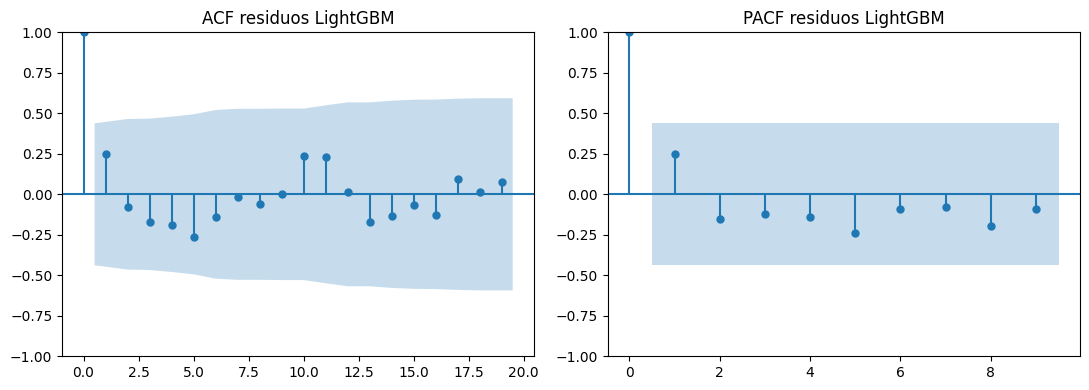

      lb_stat  lb_pvalue
19  20.531325   0.363265
9    6.219474   0.717767


In [33]:
# === 10) Análisis de residuos: ACF, PACF y Ljung–Box para LightGBM ===

# Aseguramos misma longitud e índice temporal
index_values = y_test.index
n = min(len(index_values), len(y_true_eval), len(y_pred_eval))

# Crear la serie de residuos
resid_lgbm = pd.Series(
    np.asarray(y_true_eval[:n], dtype=float) - np.asarray(y_pred_eval[:n], dtype=float),
    index=pd.to_datetime(index_values[:n]),
    name="resid_lgbm"
).dropna()

# Centrar residuos en media cero
resid_lgbm = resid_lgbm - resid_lgbm.mean()

# Número de lags para ACF y PACF (igual filosofía que en tu código original)
lags_acf  = max(1, min(24, len(resid_lgbm) - 1))
lags_pacf = max(1, min(24, len(resid_lgbm)//2 - 1))

# Gráficos ACF y PACF
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
plot_acf(resid_lgbm, lags=lags_acf, ax=ax[0])
plot_pacf(resid_lgbm, lags=lags_pacf, ax=ax[1], method="ywm")
ax[0].set_title("ACF residuos LightGBM")
ax[1].set_title("PACF residuos LightGBM")
plt.tight_layout()
plt.show()

# Test de Ljung–Box para comprobar autocorrelación remanente
ljung = sm.stats.acorr_ljungbox(resid_lgbm, lags=[lags_acf, lags_pacf], return_df=True)
print(ljung)

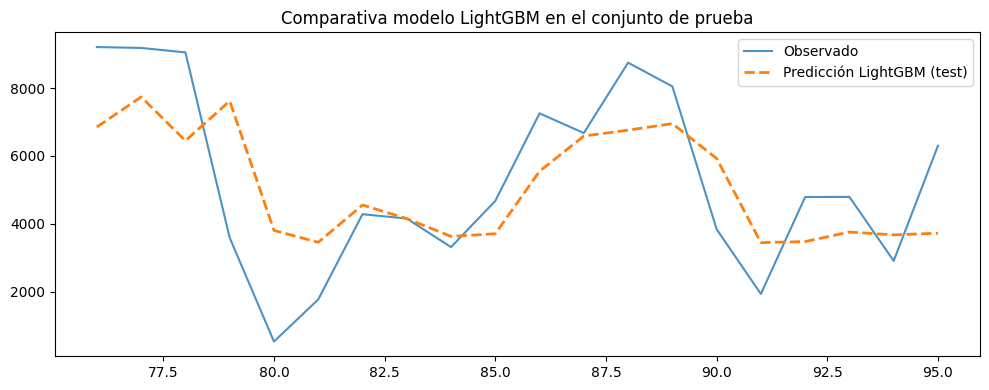

In [34]:
# === 11) Comparativa de predicciones en el conjunto de prueba ===

plt.figure(figsize=(10,4))

# Aseguramos que usamos el índice del TEST de LightGBM
idx = y_test.index

# Por si acaso, alineamos longitudes
n = min(len(idx), len(y_test), len(y_pred))

# Aseguramos que las longitudes son iguales
idx_plot      = idx[:n]
y_real_plot   = y_test.values[:n]
y_pred_plot   = np.asarray(y_pred)[:n]

# Gráfico de comparativa
plt.plot(idx_plot, y_real_plot, label="Observado", alpha=0.8)
plt.plot(idx_plot, y_pred_plot, "--", label="Predicción LightGBM (test)", linewidth=2)
plt.title("Comparativa modelo LightGBM en el conjunto de prueba")
plt.legend()
plt.tight_layout()
plt.show()



Top 20 features por importancia:
                feature  importance
11             y_lag_12         513
12             y_lag_18         427
20             y_diff_6         384
43            ICC_lag_1         336
9               y_lag_6         316
10              y_lag_9         301
35   Temperatura_lag_12         251
5                   ICC         237
7               y_lag_1         235
16        y_roll_mean_9         183
31  Precipitación_lag_1          95
6             Tendencia          71
13             y_lag_24          65
47     Tendencia_lag_12          36
14        y_roll_mean_3          31
19             y_diff_1          28
18         y_roll_std_6          22
44           ICC_lag_12           4
2           Temperatura           2
17       y_roll_mean_12           2


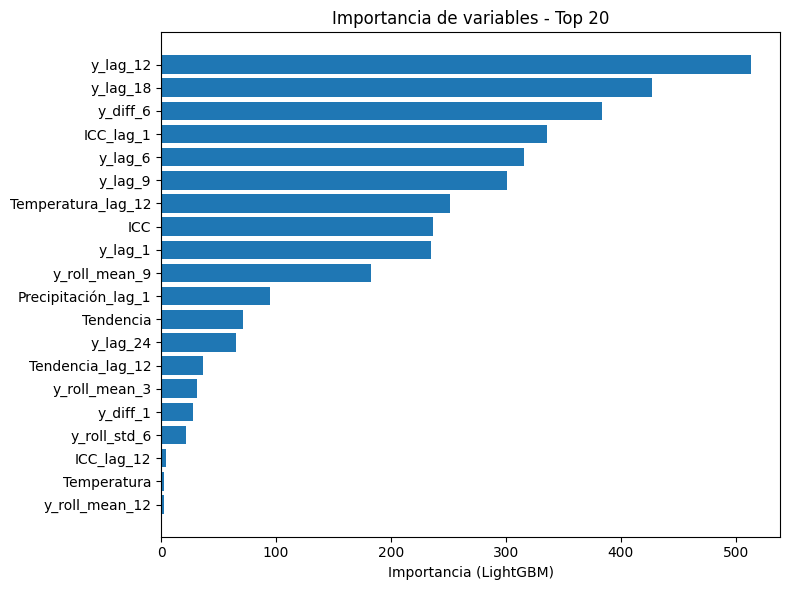

In [35]:
# === 12) Importancia de las variables del modelo ===
importances = modelo.feature_importances_ # Importancias de las variables del modelo
feat_names = X_train.columns # Lista de nombres de las variables del modelo

# Crear un DataFrame con las importancias de las variables
fi = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Imprimir las 20 características más importantes
print("Top 20 features por importancia:")
print(fi.head(20))

# Visualización de las importancias de las variables
plt.figure(figsize=(8, 6))
plt.barh(fi['feature'].head(20), fi['importance'].head(20))
plt.gca().invert_yaxis()
plt.xlabel("Importancia (LightGBM)")
plt.title("Importancia de variables - Top 20")
plt.tight_layout()
plt.show()